# AlphaPose and Downstream Modelling Pipeline

This notebook contains the entire pipeline for extracting pose features from a given video, along with applying all of our downstream models on those extracted pose features.

It represents the combination of all of our models, which can then be used to make predictions on new scenes and provide these to the API & Dashboard.

**Required TO-DO:**
- Everyone needs to integrate their downstream model(s) into this pipeline, through defining helper functions for preprocessing, prediction, and post-processing to give the outputs needed for the dashboard (see below code for instructions).
- Once done, this will give us a pipeline that can be run on either CPU or GPU as required! 👍 👍

## 1. Installation of dependencies / Importing packages

Install MXNet and Gluoncv libraries. If GPU is in use, also install mxnet-cu101 (requires runtime restart after):

In [1]:
import cv2
import io
import mxnet as mx
import gluoncv

import os
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import skimage.io
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity
from collections import deque

from gluoncv.model_zoo import get_model
from gluoncv.data.transforms.pose import detector_to_alpha_pose, heatmap_to_coord
from gluoncv.utils.viz import cv_plot_image, cv_plot_keypoints, plot_image, cv_plot_bbox
from gluoncv import utils

from matplotlib.lines import Line2D
import seaborn as sns
from tensorflow import keras
from tqdm import tqdm

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/Users/benjaminfraser/anaconda3/envs/nlp_cp/lib/python3.9/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.0` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [2]:
sns.set_style('white')

## 2. Setting up models, data and directories:

### 2.1 Image Classification Model Loading and Initialisation

**Note:** In order to get this working, you need to make sure you've got all of the files from the github repo, including the model and clf_model directory within that. This contains the pre-trained image classification model that is required.

**Option 1**: If working locally on laptop, in file system outside main repo:

In [3]:
os.getcwd()

'/Users/benjaminfraser/Desktop/GDP_group5/notebooks'

In [4]:
# get project path and other key directories for project
#PROJECT_PATH = '/Users/benjaminfraser/Desktop'

# set path to test videos to use in this notebook
#TEST_VIDEO_DIR = os.path.join(PROJECT_PATH, 'test_video_data')

# define our model directory to obtain models as needed
#MODEL_DIR = os.path.join(PROJECT_PATH, 'Multipose_experiments')

**Option 2**: If running code locally within cloned GitHub repo:

In [4]:
# get project path and other key directories for project
PROJECT_PATH = os.sep.join(os.getcwd().split(os.sep)[:-1])
DATA_DIR = os.path.join(PROJECT_PATH, 'data')

# set path to test videos to use in this notebook
TEST_VIDEO_DIR = os.path.join(DATA_DIR, 'test_videos')

# define our model directory to obtain models as needed
MODEL_DIR = os.path.join(PROJECT_PATH, 'models')

Only ensure one of the two code snippets above are uncommented, and relate to the correct directories.

Load pre-trained BiT model for mask classification:

In [5]:
# define folder that contains our trained model
saved_model_dir = os.path.join(MODEL_DIR, 'mask_clf_model')

# if not already done, load existing trained model
trained_module = hub.KerasLayer(saved_model_dir, trainable=False)

2022-03-28 18:23:14.205235: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 18:23:25.772375: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 're_lu_48/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2022-03-28 18:23:25.772416: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'global_average_pooling2d/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 4 outputs. Output shapes may be inaccurate.


Load pre-trained FCNN model for performing behaviour analysis:

In [6]:
# load bahavior analysis model
behavior_analysis_model_dir = os.path.join(MODEL_DIR, 'pose_ana_model', 'four_behavior.h5')
behavior_analysis_model = tf.keras.models.load_model(behavior_analysis_model_dir)

Set up main environment variables for the above mask classification model:

In [7]:
# if images are generally small (smaller than 96 x 96 on avg)
IMG_SIZE = (160, 160)
RESIZE_TO = 128
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# probability theshold for classifying a person as masked
MASK_THRESHOLD = 0.7

# class id map for our mask model predictions
CLASS_ID_MAP = { 0 : 'No Mask',
                 1 : 'Mask'}

# color map dictionary for different classes
COLOR_MAP = {0 : [255.0, 0.0, 0.0],
             1 : [0.0, 255.0, 0.0]}

# ID mappings and color map for behaviour classification
BEH_DIC = {1:"Standing",2:"Sittting",3:"Walking",4:"Lying Down"}
BEH_color = {0:[225, 0, 0], 2:[0, 225, 0], 3:[0, 0, 225], 4:[225, 225, 0]}

### 2.2 AlphaPose Model Loading and Initialisation

Load and initialise our AlphaPose model (select CPU or GPU as required!):

In [8]:
# initialise our alphapose model - either cpu or gpu subject to architecture
ctx = mx.cpu()
#ctx = mx.gpu()

# load and initialise object detector that feeds into AlphaPose
detector = get_model('yolo3_darknet53_coco', pretrained=True, ctx=ctx)

# other object detection model options:
# faster & smaller, but slight drop in performance
#detector = get_model('yolo3_mobilenet1.0_coco', pretrained=True, ctx=ctx)

# slightly faster, but worse performing option using single-shot-detector:
#detector = get_model('ssd_512_mobilenet1.0_coco', pretrained=True, ctx=ctx)

detector.reset_class(classes=['person'], reuse_weights={'person':'person'})
detector.hybridize()

# Load and initialise AlphaPose model (estimates poses from dectector outputs)
estimator = get_model('alpha_pose_resnet101_v1b_coco', pretrained=True, ctx=ctx)
estimator.hybridize()

We can now apply this AlphaPose model on a desired video / stream, by making predictions on each frame as it is received. We'll do this for an example video, as shown below:

### 2.3 Configure test video / scenes location for running our script:

Set path to .mp4 video to run pipeline on:

In [9]:
# set filename and path for chosen test video for this notebook
TEST_VIDEO_FILE = 'campus_1.mp4'
TEST_VIDEO_FILEPATH = os.path.join(TEST_VIDEO_DIR, TEST_VIDEO_FILE)

## 3. Defining helper functions for all downstream models

Within this section we require helper functions that allow each of our downstream models to pre-process, make predictions and post-process predictions from the extracted pose features.

### 3.1 Distance estimation helper **functions**

[Define all helper functions needed for preprocessing pose features and computing the distance results needed for the dashboard here...]

In [10]:
def to_3D(xf, yf, xh, yh, f, h=1.5):
    """ Gives the 3D euclidian coordinates of a person (on feet position) given
        its head and feet 2D coordinates in the image, the focal length of the
        camera and the average  (with origin of 3D coordinates system projected
        on the center of the 2D image, center of 2D coordinates system)

    Args:
        xf (float): abscissa of the feet position in the image
        yf (float): ordinate of the feet position in the image
        xh (float): abscissa of the head position in the image
        yh (float): ordinate of the head position in the image
        f (float): focal length of the camera
        h (float): average nose-to-feet height of a person (default 1.5)
                
    Method:
        Remove every error sensible operations or special cases, and do:
        x = xh*h/((f*(1-xh/xf))**2 + ((yh*xf-xh*yf)/xf)**2)**0.5
        H = x/xf*(f*(1-(x*(yh*xf-xh*yf)/(xh*xf*h))**2)**0.5
            - x*yf*(yh*xf-xh*yf)/(xh*xf*h))
        y = x*yf/xf/(1-(x*(yh*xf-xh*yf)/(xf*xh*h))**2)**0.5
        theta = np.arccos(x*(yh*xf-xh*yf)/(xf*xh*h))
    
    Returns:
        x (float): position of the person's feet along x-axis (axis located on the floor)
        y (float): position of the person's feet along y-axis (axis located on the floor)
        theta (float): angle of the camera from the ceiling, in rad
        H (float): height of the camera
    """
    # particular case, avoid division by 0 with simpler equations
    if xf * xh == 0:
        x = 0
        temp1 = (yh - yf)/h

        # case due to high error on the given coordinates
        if abs(temp1) >= 1:
            # fix values such as it can be removed later, in particular with H = -1
            return 0, 0, 0, -1 
        
        temp2 = (1-temp1**2)**0.5
        H = f*temp2 - yf*temp1
        y = yf/temp2
        theta = np.arccos(temp1)

    else:
        # case due to high error or if top view and person in (0, 0)
        if xh == xf and yh == yf:
            # fix values such as it can be removed later, in particular with H = -1
            return 0, 0, 0, -1

        x = xh*h/((f*(1-xh/xf))**2 + (yh-xh*yf/xf)**2)**0.5
        temp1 = (yh/xh - yf/xf)/h

        # case due to high error on the given coordinates
        if abs(x*temp1) >= 1:
            return 0, 0, 0, -1
        
        temp2 = (1-(x*temp1)**2)**0.5
        H = x/xf*(f*temp2 - x*yf*temp1)
        y = x*yf/(xf*temp2)
        theta = np.arccos(x*temp1)
        
    return x, y, theta, H

In [11]:
def from_2D_to_3D(pose_feats, image_dim_x, image_dim_y, theta=None, H=None, f=None):
    """ Gives the 3D euclidian coordinates of the persons in a image (on feet
        position) given their heads and feet 2D coordinates in the image, and
        the dimensions of the image (with origin of 3D coordinates system
        projected on the center of the 2D image, center of 2D coordinates system)

    Args:
        image_keypoints (mxnet.nd.NDArray): 2D array containing x and y co-ords columns
                                            for the 17 COCO keypoints (17 rows)
        image_dim_x (float): width of the image
        image_dim_y (float): height of the image
        theta (float): angle of the camera from the ceiling, in rad (default None)
        H (float): height of the camera
        f (float): focal length of the camera (default None)

    Returns:
        X (numpy.ndarray): positions of the persons' feet along x-axis (axis located on the floor)
        Y (numpy.ndarray): positions of the persons' feet along y-axis (axis located on the floor)
        theta (float): angle of the camera from the ceiling, in rad (default None)
        H (float): height of the camera (default None)
        f (float): focal length of the camera (default None)
    """
    image_keypoints = pose_feats.asnumpy()
    n_persons = image_keypoints.shape[0]
    eps = np.pi / 2 / 100
    
    # initialize some variables whether to determine theta or H
    if theta:
        theta_defined = True
    else:
        theta_defined = False
    if H:
        H_defined = True
    else:
        H_defined = False
    
    # translate the positions to the right 2D coordinate system
    feet = np.zeros((n_persons, 2))
    nose = np.zeros((n_persons, 2))
    for index in range(n_persons):
        # get keypoints of the person
        p = image_keypoints[index]

        # from img_array coordinates to 2D euclidian coordinates where origin is image center
        feet[index] = ((p[-1, 0]+p[-2, 0])/2 - image_dim_x/2, 
                       image_dim_y/2 - (p[-1, 1]+p[-2, 1])/2)
        
        nose[index] = p[0, 0] - image_dim_x/2, image_dim_y/2 - p[0, 1]
    
    # determine f if not given (with trichotomy)
    if not f:
        # interval boundaries for trichotomy (here 30° < FOV < 120°)
        b = [image_dim_x / (2 * np.tan(120/180 * np.pi/2)), 
             image_dim_x / (2 * np.tan(30/180 * np.pi/2))]
        # f = d_image / (2 * np.tan(FOV/180 * np.pi/2))

        while b[1]-b[0] > np.mean(b) / 50: # maximum 1% error on value found

            # trichotomy first third value
            f_test = b[0]+(b[1]-b[0])/10
            
            # determine 3D positions, theta and H for each person
            res = np.zeros((n_persons, 4))
            for i in range(n_persons):
                res[i] = to_3D(feet[i, 0], feet[i, 1], nose[i, 0], nose[i, 1], f_test)
            
            # remove wrong values
            selected = (res[:, 3] > 1) * (res[:, 2] > eps) * (res[:, 2] < np.pi/2 - eps)

            if np.sum(selected) == 0:
                selected = np.ones(n_persons, dtype=bool)

            # if not given, estimate theta and H: median to avoid outliers impact
            if not theta_defined:
                theta = np.median(res[selected, 2])
            if not H_defined:
                H = np.median(res[selected, 3])
            
            # calculate median error on positions: median to avoid outliers impact
            temp = f_test*np.sin(theta) / (H + np.sin(theta)*np.cos(theta)*res[selected, 1])
            r1 = np.median((temp*res[selected, 0] - feet[selected, 0])**2
                            + (temp*res[selected, 1]*np.sin(theta) - feet[selected, 1])**2)

            # trichotomy second third value
            f_test = b[0]+9*(b[1]-b[0])/10
            
            # determine 3D positions, theta and H for each person
            res = np.zeros((n_persons, 4))
            for i in range(n_persons):
                res[i] = to_3D(feet[i, 0], feet[i, 1], nose[i, 0], nose[i, 1], f_test)
            
            # remove wrong values
            selected = (res[:, 3] > 1) * (res[:, 2] > eps) * (res[:, 2] < np.pi/2 - eps)
        
            if np.sum(selected) == 0:
                selected = np.ones(n_persons, dtype=bool)
                
            # if not given, estimate theta and H: median to avoid outliers impact
            if not theta_defined:
                theta = np.median(res[selected, 2])
            if not H_defined:
                H = np.median(res[selected, 3])
            
            # calculate median error on positions: median to avoid outliers impact
            temp = f_test*np.sin(theta) / (H + np.sin(theta)*np.cos(theta)*res[selected, 1])
            r2 = np.median((temp*res[selected, 0] - feet[selected, 0])**2
                            + (temp*res[selected, 1]*np.sin(theta) - feet[selected, 1])**2)
            
            # compare values and update the interval boundaries
            if r1 > r2:
                b[0] = b[0]+(b[1]-b[0])/10
            else:
                b[1] = b[0]+9*(b[1]-b[0])/10
        
        # finally take the center of interval as value found
        f = np.mean(b)
    
    if not theta_defined or not H_defined:
        # final iteration with found/given f value
        res = np.zeros((n_persons, 4))
        for i in range(n_persons):
            res[i, :] = to_3D(feet[i, 0], feet[i, 1], nose[i, 0], nose[i, 1], f)

        # remove wrong values
        selected = (res[:, 3] > 1) * (res[:, 2] > eps) * (res[:, 2] < np.pi/2 - eps)
        
        if np.sum(selected) == 0:
            selected = np.ones(n_persons, dtype=bool)
    
        # If not given, estimate theta and H: use density to increase precision
        if not theta_defined:
            d_theta = np.median(res[selected, 2])
            density_range_theta = np.linspace(min(res[selected, 2]), 
                                              max(res[selected, 2]), 200)
            kde_skl = KernelDensity(bandwidth=d_theta)
            kde_skl.fit(res[selected, 2, np.newaxis])
            log_pdf = kde_skl.score_samples(density_range_theta[:, np.newaxis])
            density_theta = np.exp(log_pdf)
            theta = density_range_theta[np.argmax(density_theta)]
            
        if not H_defined:
            d_H = np.median(res[selected, 3])
            density_range_H = np.linspace(min(res[selected, 3]), max(res[selected, 3]), 200)
            kde_skl = KernelDensity(bandwidth=d_H)
            kde_skl.fit(res[selected, 3, np.newaxis])
            log_pdf = kde_skl.score_samples(density_range_H[:, np.newaxis])
            density_H = np.exp(log_pdf)
            H = density_range_H[np.argmax(density_H)]
    
    # 3D positions (top view)
    Y = H * feet[:, 1] / (f*np.sin(theta)**2 - feet[:, 1]*np.cos(theta)*np.sin(theta))
    X = Y * feet[:, 0] * np.sin(theta) / feet[:, 1]
    
    return X, Y, theta, H, f

In [12]:
def get_respect_social_distancing(positions, social_distance=2):
    """ Get social distancing labels (0 = no respect, 1 = respect)

    Args:
        positions (numpy.ndarray): positions of people
        social_distance (float): social distancing treshold (default 2)
    
    Returns:
        respect_social_distancing (numpy.ndarray): whether the persons repect social
                                                   distancing (0 = no, 1 = yes)
    """
    # compute the distance matrix then find wheter people are respecting
    respect_social_distancing = (np.sum(
        np.linalg.norm(
            positions[:, None, :] - positions[None, :, :], axis=-1) 
        < social_distance, axis = 0) == 1).astype(int)

    return respect_social_distancing

Helper function for plotting top-view of the scene (useful for confirming results / implementation is correct):

In [13]:
def plot_top_view(positions, H, theta, f, image_dim_x, image_dim_y, figsize=(7,6)):
    """ Helper function for plotting top-view of the scene for chosen images 
    
    Args:
        positions (numpy.ndarray): positions of people
        H (float): camera height
        theta (float): camera angle from ceiling, in rad
        f (float): camera focal length
        figsize (tuple): tuple of desired figure size to plot
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # get observed area
    limits = np.array([[-image_dim_x/2, -image_dim_y/2], 
                       [-image_dim_x/2, image_dim_y/2], 
                       [image_dim_x/2, image_dim_y/2], 
                       [image_dim_x/2, -image_dim_y/2], 
                       [-image_dim_x/2, -image_dim_y/2]])
    
    limits_y = (H * limits[:, 1] / 
            (f*np.sin(theta)**2 - limits[:, 1]*np.cos(theta)*np.sin(theta)))
    
    limits_x = limits_y * limits[:, 0] * np.sin(theta) / limits[:, 1]
    ax.plot(limits_x, limits_y, '--k', linewidth = 1, alpha = 0.5)            
    
    # get axis and limits
    m_x, M_x = np.min(limits_x), np.max(limits_x)
    m_y, M_y = np.min(limits_y), np.max(limits_y)
    limits_abs = np.array([[-dim_x/2, 0], [dim_x/2, 0]])
    limits_abs_x = H * limits_abs[:, 0] / (f*np.sin(theta) - limits_abs[:, 1]*np.cos(theta))
    
    ax.plot([0, 0], [m_y, M_y], '-k', linewidth = 2, alpha = 0.2)
    ax.plot(limits_abs_x, [0, 0], '-k', linewidth = 2, alpha = 0.2)

    # plot positions of people
    ax.scatter(positions[:, 0], positions[:, 1], c='red', marker='o', s=15)
    
    ax.set_aspect('equal')
        
    # hide our x and y-ticks on the axes
    ax.axis('off')
    
    plt.show()
    return

### 3.2 Clustering helper functions

In [14]:
def get_clusters(positions, treshold=1):
    """ Get clusters information (number of clusters and persons' clusters labels)

    Args:
        positions (numpy.ndarray): positions of people
        treshold (float): maximum distance separating a person from the closest person
                          in the cluster (default 1)
    
    Returns:
        persons_clusters (numpy.ndarray): clusters to which each person belongs
    """
    # compute the clusters, where a cluster is made by persons less than a 
    # treshold distance from another one of the same cluster
    clusters = DBSCAN(eps=treshold, min_samples=2).fit(positions)
    persons_clusters = clusters.labels_
    
    return persons_clusters

Helper function for plotting clustering (useful for confirming results / implementation is correct):

In [15]:
def plot_clusters(img, persons_clusters, bounding_boxs, figsize=(7,6)):
    """ Helper function for plotting clusters for chosen images (black is no cluster)
    
    Args:
        img (numpy.ndarray): original image array
        persons_clusters (numpy.ndarray): clusters to which each person belongs
        bounding_boxs (numpy.ndarray or mxnet.nd.NDArray): bounding boxes
        figsize (tuple): tuple of desired figure size to plot
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    if isinstance(bounding_boxs, mx.nd.NDArray):
        bounding_boxs = bounding_boxs.asnumpy()

    # bouding boxes colors
    colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255],
                      [255, 255, 0], [255, 0, 255], [0, 255, 255],
                      [255, 255, 255], 
                      [127, 0, 0], [0, 127, 0], [0, 0, 127],
                      [127, 127, 0], [127, 0, 127], [0, 127, 127],
                      [127, 127, 127],
                      [0, 0, 0]]) / 255

    for i, box in enumerate(bounding_boxs):
        x_min, y_min, x_max, y_max = box

        # plot bbox in appropriate color
        rect = mpatches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                                  linewidth=2, edgecolor=colors[persons_clusters[i]], 
                                  facecolor='none')
        ax.add_patch(rect)

    # hide our x and y-ticks on the axes
    ax.axis('off')

    ax.imshow(img)
    plt.show()
    return

### 3.3 Pose classification helper functions

Helper functions needed for preprocessing pose features and computing the status of people from pose features:

In [16]:
def behavior_analysis(pose_feats, bbox, model):
    """Using 34 cooradinate value of pose features and model to analyze behavior
      TODO: 1.adding information of bounding box as input
            2.adding behavior class, others, for other or unclear behaviors

    Args:
        pose_feats (mxnet array) : 2D array containing x and y co-ords
                  columns for the 17 COCO keypoints (17 rows).
        bbox (mxnet array) : 1D array containing bounding box information
        model (tf.keras.models.Sequential()) : FCNN model for behavior analysis
  
    Return:
        behavior_class (str) : name of behavior class, including standing, sitting, walking, and lying down
        score (flost) : Score of classification results
    """
    # Prepare data
    pose_feats = pred_coords.asnumpy()
    # Normalize data
    result = (pose_feats[:, :, 0].T - bbox[:, 0]) / (bbox[:, 2] - bbox[:, 0])
    pose_feats[:, :, 0] = result.T
    result = (pose_feats[:, :, 1].T - bbox[:, 1]) / (bbox[:, 3] - bbox[:, 1])
    pose_feats[:, :, 1] = result.T
    pose_feats = pose_feats.reshape(pose_feats.shape[0], -1)
    # predict class and get label and score
    result = model.predict(pose_feats)
    label = np.argmax(result, axis=1)
    score = np.max(result, axis=1)
    return label, score

### 3.4 Image classification model helper functions

Helper functions are defined below for doing the following:
- Computing suitable head regions for all people in a scene using pose features
- Obtaining numpy array of all head regions from a given image array
- Obtaining a tensorflow tensor data object of the head regions, including preprocessing required for the classification model
- Pre-trained classification model functions for predicting masks for given input tensor of head regions.

In [17]:
def compute_head_boxes(pose_feats, factor=1.1):
    """ Obtain bounding box of heads using head average
        co-ordinates and torso length as a rough guide. 
    
    Args:
        pose_feats (mxnet array) : 2D array containing x and y co-ords
                columns for the 17 COCO keypoints (17 rows).
        factor (float) : factor to multiply torso length by for the
                        extracted head region (default 1.0)
    Returns:
        head_regions (np.array) : Array with head region box co-ordinates
            in the form [x_mins, y_mins, w, h] for each person (row).
    """
    # calculate the average head x and y coords
    head_x_avgs = pose_feats[:,:5,0].mean(axis=1).asnumpy().reshape(-1, 1)
    head_y_avgs = pose_feats[:,:5,1].mean(axis=1).asnumpy().reshape(-1, 1)
    head_avgs = np.column_stack([head_x_avgs, head_y_avgs])
    
    # calculate left-ear to right-ear abs x dist as approx head width
    head_widths = np.abs(pose_feats[:,4,0].asnumpy() - 
                         pose_feats[:,3,0].asnumpy()).reshape(-1, 1)
    
    # calculate average shoulder co-ordinates
    shoulder_x_avgs = pose_feats[:,5:7,0].mean(axis=1).asnumpy().reshape(-1, 1)
    shoulder_y_avgs = pose_feats[:,5:7,1].mean(axis=1).asnumpy().reshape(-1, 1)
    shoulder_avgs = np.column_stack([shoulder_x_avgs, shoulder_y_avgs])

    # calculate average waist (hip) co-ordinates
    waist_x_avgs = pose_feats[:,11:13,0].mean(axis=1).asnumpy().reshape(-1, 1)
    waist_y_avgs = pose_feats[:,11:13,1].mean(axis=1).asnumpy().reshape(-1, 1)
    waist_avgs = np.column_stack([waist_x_avgs, waist_y_avgs])
    
    # calculate torso length using obtained co-ordinates
    torso_lengths = np.linalg.norm(shoulder_avgs - 
                    waist_avgs, axis=1).astype(int).reshape(-1, 1)
    
    # ensure torso length is at least 2x head_width - adjust otherwise
    torso_lengths = np.maximum(torso_lengths, head_widths*2)
    
    # adjust torso lengths based on multiplier factor given
    torso_lengths = (torso_lengths*factor).astype(int).reshape(-1, 1)
    
    # find head box xmins, ymins, widths and heights
    x_mins = head_x_avgs - (torso_lengths / 2.0)
    y_mins = head_y_avgs - (torso_lengths / 2.0)
    w = torso_lengths.copy()
    h = torso_lengths.copy()
    
    # ensure xmins and y mins are not below zero:
    x_mins = np.maximum(x_mins, 0).astype(int)
    y_mins = np.maximum(y_mins, 0).astype(int)
    
    
    
    return np.column_stack([x_mins, y_mins, w, h])

In [18]:
def get_image_region_array(img_array, head_regions, 
                           normalise=True,
                           reshape_size=(RESIZE_TO, RESIZE_TO)):
    """ Helper function to gather head regions tensor.

    Args:
        df (pd.DataFrame) : pandas dataframe with pose results.
        img_name (str) : string containing exact name of image to plot.
        image_dir (str) : string containing path to image directory.
    
    Returns:
        tensor_stack (tf tensor) : tensor with resized image regions.
    """
    
    # get x max and y max of img to ensure we don't go out-of-bounds
    y_max, x_max = img_array.shape[:2]
    
    # create a list of numpy arrays with our images
    img_stack = [np.expand_dims(
                    img_array[reg[1]: reg[1] + reg[3], 
                              reg[0]: reg[0] + reg[2]], axis=0) 
                 for reg in head_regions]

    # convert list of np arrays into ragged tensor
    tensor_stack = tf.ragged.constant(img_stack)

    # resize all images within our ragged tensor
    tensor_stack = tf.concat(
        [tf.image.resize(tensor_stack[i].to_tensor(), reshape_size) 
         for i in tf.range(tensor_stack.nrows())], axis=0)
    
    if normalise:
        tensor_stack = tensor_stack / 255.0
    
    return tensor_stack

In [19]:
# define softmax layer to use for normalising logit outputs
softmax_layer = tf.keras.layers.Softmax()

def model_predict_probs(model, image_batch, softmax=True):
    """ Helper function for making probability predictions 
        on an image batch 

    Args:
        model (TFHub Model) : Trained model for making predictions.
        image_batch (tf.tensor) : Tensor containing images for prediction.
        softmax (bool) : Whether to apply softmax activation or not.
    
    Returns:
        preds (np.array) : 2D output array of image predictions. First column 
                           is output for mask, second is for no_mask.
    """
    preds = model(image_batch)
    if softmax:
        return softmax_layer(preds).numpy()
    else:
        return preds

def get_prediction_labels(preds, threshold=None):
    """ Get output prediction labels (0 = no_mask, 1 = mask) 
    
    Args:
        preds (np.array) : 2d array containing class probabilities.
        threshold (float) : class threshold, based on second preds column.
    """
    # if theshold chosen, find label based on probability
    if threshold is not None:
        return tf.where(preds[:, 1] >= threshold, 1, 0)
    # otherwise simply return argmax for class label
    else:
        return tf.argmax(preds, axis=1)

Helper function for plotting image classification model predictions (useful for confirming results / implementation is correct):

In [20]:
def plot_mask_predictions(img, labels, pred_probs, 
                          head_regions,
                          color_map=COLOR_MAP, 
                          figsize=(7,6), 
                          legend=False,
                          plot_proportion=True):
    """ Helper function for plotting predictions for chosen images 
    
    Args:
        img (np.array) : Original image array.
        labels (np.array) : Predicted class labels.
        confidences (np.array) : Probabilities for predicted classes.
        color_map (dict) : dictionary mapping class output labels.
        figsize (tuple) : tuple of desired figure size to plot.
        legend (bool) : Whether to show legend or not, default false.
        box_col (str) : Column containing bbox regions to plot.
    """
    # keep only first column as predicted confidence
    confidences = list(pred_probs[:, 1])

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # plot each bbox and annotate confidence
    for i, box in enumerate(head_regions):
        
        # get co-ords for current bbox
        x_min, y_min, w, h = box
        
        # if mask, annotate green
        if labels[i] == 1:

            # plot current predicted bbox in green
            pred_rect = mpatches.Rectangle((x_min, y_min), w, h, 
                                        linewidth=2, edgecolor='g', 
                                        facecolor='none')

            ax.text(x_min, y_min - 5, f"{confidences[i]:.2f}", 
                    bbox={"facecolor": "tab:green", "alpha": 0.4},
                    clip_on=True)
            
        else:
            # plot predicted non-mask in red
            pred_rect = mpatches.Rectangle((x_min, y_min), w, h, 
                                        linewidth=2, edgecolor='r', 
                                        facecolor='none')
        
            ax.text(x_min, y_min - 5, f"{1.0 - confidences[i]:.2f}", 
                    bbox={"facecolor": "tab:red", "alpha": 0.4},
                    clip_on=True)
        
        # add each bbox to plot
        ax.add_patch(pred_rect)
    
    # if legend chosen, annotate what class is which color
    if legend:
        # map color map colors to matplotlib style colors
        mpl_color_map = dict()
        for object_name in color_map.keys():
            mpl_color_map[object_name] = tuple([i/255 for i 
                                            in color_map[object_name]])
    
        # get object names and create legend lines for each class type
        object_ids = list(color_map.keys())

        object_names = [CLASS_ID_MAP[id] for id in object_ids]
    
        legend_lines = [Line2D([0],[0], 
                               color=mpl_color_map[object_ids[i]], 
                               lw=2) 
                        for i in range(len(object_ids))]
        plt.legend(legend_lines, object_names, loc='best')
    
    # if plot proportion chosen, annotate mask % as title of fig
    if plot_proportion:
        # get mask proportion - No. of '1' labels out of total
        mask_prop = np.array(np.bincount(labels)[1] / labels.shape[0])
        plt.title(f"Mask Proportion: {mask_prop * 100:.2f}%", weight="bold")
    
    # hide our x and y-ticks on the axes
    ax.axis('off')

    ax.imshow(img)
    plt.show()
    return

## 4. Running AlphaPose on video example and obtaining all downstream modelling results:

All of our downstream models can be run on the video frames as they are processed by our AlphaPose model.

For each downstream model, we need to implement our modelling techniques (preprocessing, prediction & post-processing (if required)) after the AlphaPose model obtains pose extractions for each frame (see commented code below).

This process will be done on our example video (as uploaded in section 2.3 above!):

Set basic variables for our results below:

In [21]:
# whether to plot results or not
SHOW_POSES = False
SHOW_MASK_PREDS = True

# define how often to make predictions (2 times per second by default)
# a higher modelling fps will slow the response-time of our system down
MODELLING_FPS = 2

# length to resize video short size in before detector
VID_RESIZE_SHORT = 512

Run alphapose, with downstream models on video feed:

In [22]:
# set matplotlib inline if displaying result plots
%matplotlib inline 

# reset seaborn to whitegrid by default
sns.set_style('white')

/var/folders/tl/s585rjvn73707m1x10ytl_gm0000gn/T/ipykernel_2388/1760020416.py:112: RuntimeWarning: invalid value encountered in true_divide
  np.abs((np.array(theta_queue) - np.mean(theta_queue))
/var/folders/tl/s585rjvn73707m1x10ytl_gm0000gn/T/ipykernel_2388/1760020416.py:116: RuntimeWarning: invalid value encountered in true_divide
  np.abs((np.array(H_queue) - np.mean(H_queue))
/var/folders/tl/s585rjvn73707m1x10ytl_gm0000gn/T/ipykernel_2388/1760020416.py:120: RuntimeWarning: invalid value encountered in true_divide
  np.abs((np.array(f_queue) - np.mean(f_queue))


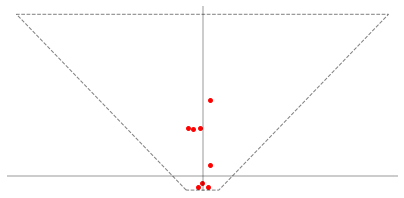

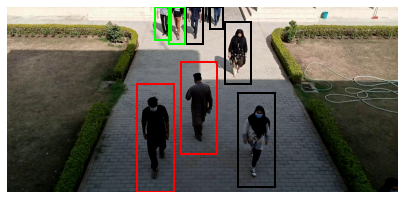

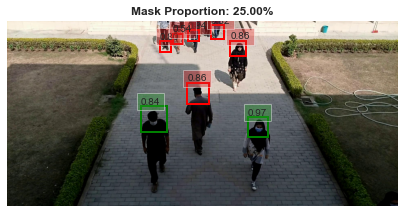

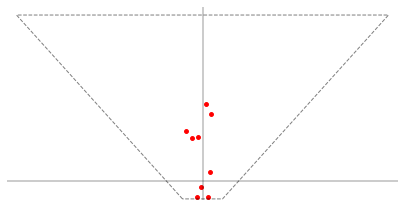

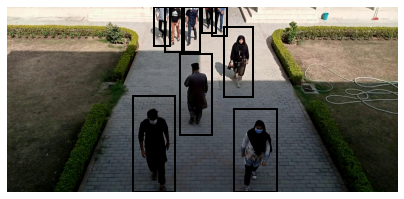

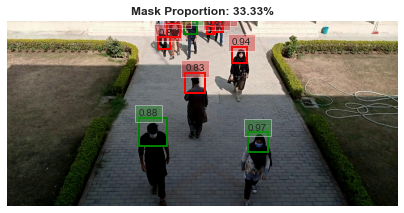

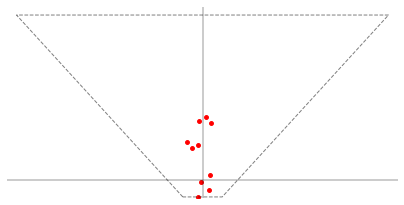

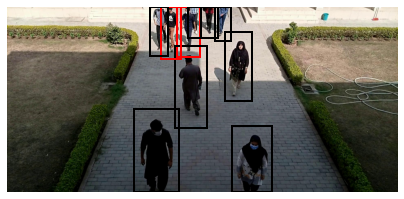

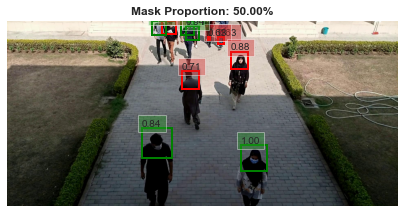

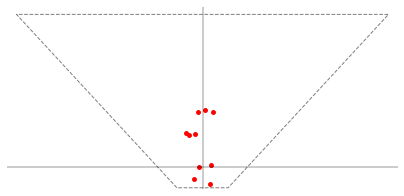

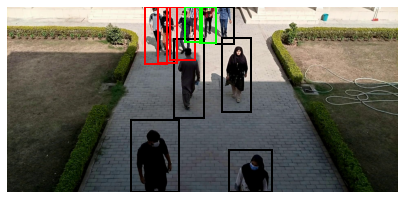

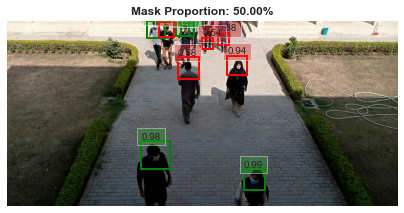

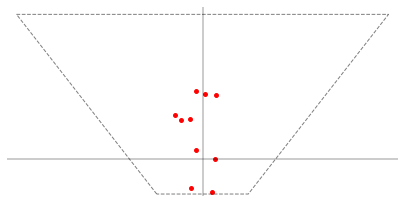

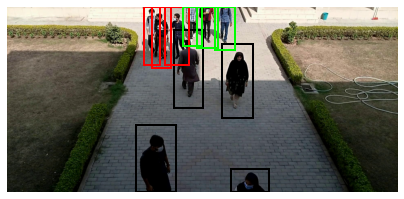

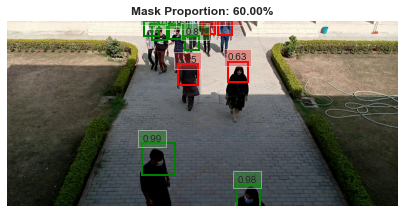

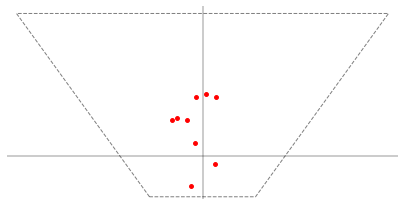

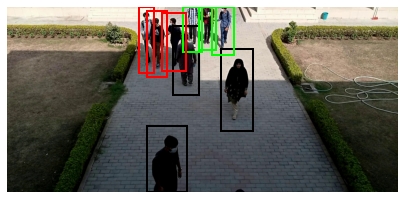

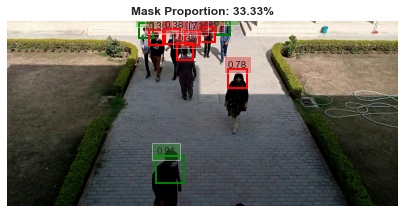

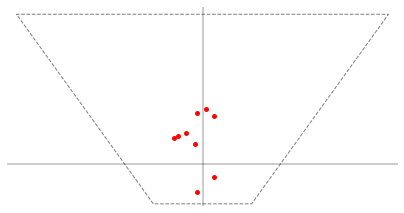

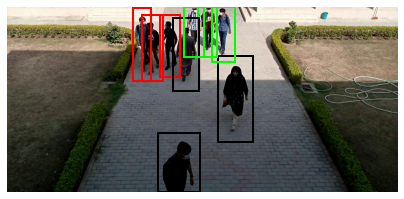

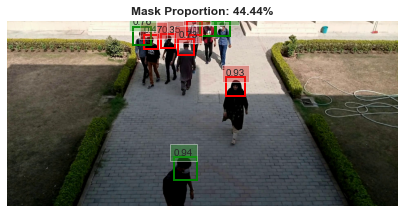

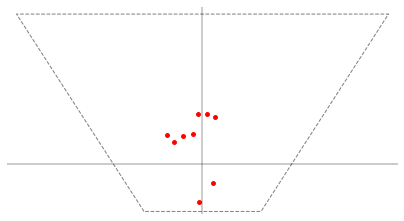

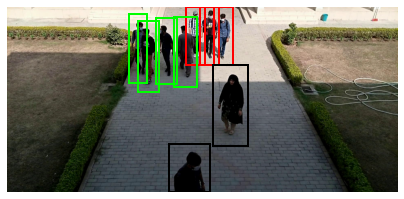

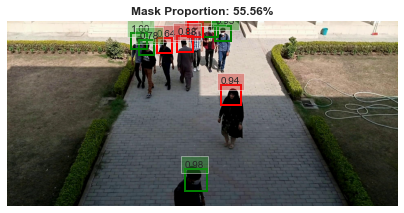

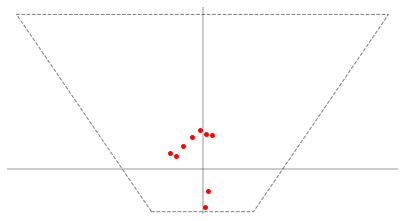

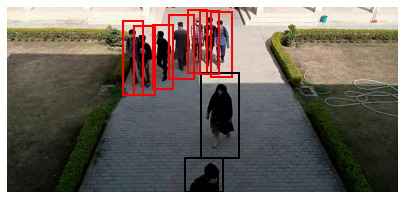

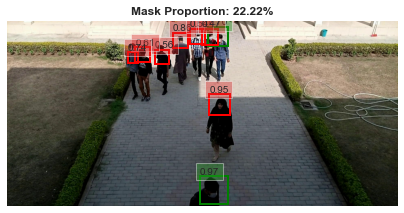

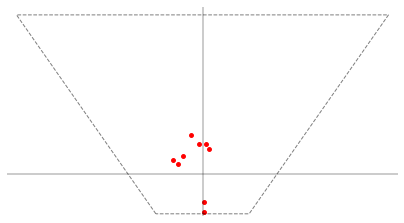

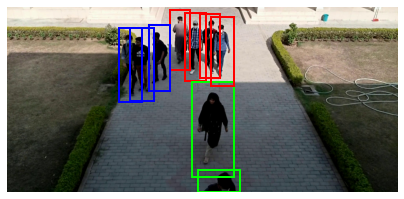

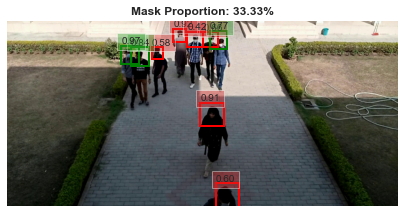

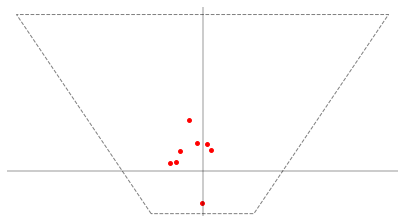

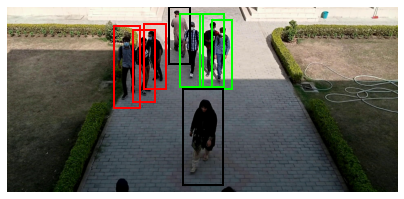

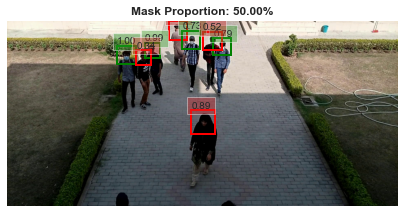

In [23]:
# load uploaded video into opencv:
cap = cv2.VideoCapture(TEST_VIDEO_FILEPATH)
fps = cap.get(cv2.CAP_PROP_FPS)

# initially current frame is zero
frame_count = 0

# dictionary for scene-summary results (e.g. person counts, mask %)
frame_results = {'image_id' : [],
                 'person_count' : [],
                 'clusters_count' : [],
                 'social_distancing_compliance' : [],
                 'mask_proportions' : [], 
                 'frame_H' : [],
                 'frame_theta' : [],
                 'frame_f' : [],
                 'frame_dim_x' : [],
                 'frame_dim_y' : []}

# dictionary for per-person level results (bbox, keypoints, mask_on etc.)
person_results = {'image_id' : [],
                  'bbox' : [],
                  'keypoints' : [],
                  'confidences' : [],
                  'position' : [],
                  'in_cluster' : [],
                  'respect_social_distancing' : [],
                  'behavior' : [],
                  'behavior_score' : [],
                  'mask_preds' : [],
                  'mask_pred_probs' : [],
                  'mask_head_regions' : []}

# parameters tracking
time_step_average = 120
theta_queue = deque()
H_queue = deque()
f_queue = deque()

# whilst processing video, do the following loop..
while(True):

    # check video capture, and obtain current frame (image from video)
    ret, frame = cap.read()

    # if our video is still being processed, do the following...
    if(ret):

        # preprocess frame as required for object detector & AlphaPose
        frame = mx.nd.array(cv2.cvtColor(frame, 
                                         cv2.COLOR_BGR2RGB)).astype('uint8')
        x, frame = gluoncv.data.transforms.presets.ssd.transform_test(frame, 
                                                        short=VID_RESIZE_SHORT)
        x = x.as_in_context(ctx)

        # obtain human bounding boxes using object detector
        class_IDs, scores, bounding_boxs = detector(x)

        # get pose estimations using AlphaPose
        pose_input, upscale_bbox = detector_to_alpha_pose(frame, class_IDs, 
                                                          scores, bounding_boxs)

        # add frame id, person count to frame-level results
        image_id = f"frame_{int(frame_count)}"
        n_people = upscale_bbox.shape[0]
        frame_results['image_id'].append(image_id)
        frame_results['person_count'].append(n_people)

        # add frame_id, person bbox to person-level results
        person_results['image_id'].append([image_id for x in range(n_people)])
        person_results['bbox'].append(upscale_bbox)

        # if we have predictions, obtain keypoint co-ords and confidences
        if upscale_bbox is not None:

            # obtain predicted heatmap
            predicted_heatmap = estimator(pose_input.as_in_context(ctx))

            # obtain keypoint co-ordinates from heatmap results
            pred_coords, confidence = heatmap_to_coord(predicted_heatmap, 
                                                       upscale_bbox)
            

            # add person keypoints and confidences to person-level results
            person_results['keypoints'].append(pred_coords.asnumpy())
            person_results['confidences'].append(confidence.asnumpy())

            ########################################################
            ######### DOWNSTREAM MODELLING PROCESSING AREA #########
            ########################################################
            
            ####### DISTANCE ESTIMATION / CLUSTERING (VALENTIN) #######
            
            # obtain x / y dims of frame
            image_dim_y, image_dim_x = frame.shape[:2]
            
            # obtain estimation of parameters of the camera 
            _, _, theta, H, f = from_2D_to_3D(pred_coords, image_dim_x, 
                                              image_dim_y)
            
            # update parameters tracking lists
            if len(theta_queue) > time_step_average:
                theta_queue.popleft()
                H_queue.popleft()
                f_queue.popleft()
            theta_queue.append(theta)
            H_queue.append(H)
            f_queue.append(f)
            
            # use z-scores to remove extreme values (95% confidence)
            zscore_select_theta = np.where(
                            np.abs((np.array(theta_queue) - np.mean(theta_queue)) 
                                   / np.std(theta_queue)) < 1.96)[0]
            
            zscore_select_H = np.where(
                        np.abs((np.array(H_queue) - np.mean(H_queue)) 
                               / np.std(H_queue)) < 1.96)[0]
            
            zscore_select_f = np.where(
                        np.abs((np.array(f_queue) - np.mean(f_queue)) 
                               / np.std(f_queue)) < 1.96)[0]
            
            zscore_select = np.intersect1d(zscore_select_theta, 
                                           np.intersect1d(zscore_select_H, 
                                                          zscore_select_f))
            # remove extreme values
            if len(zscore_select) > 10:
                theta = np.mean(np.array(theta_queue)[zscore_select])
                H = np.mean(np.array(H_queue)[zscore_select])
                f = np.mean(np.array(f_queue)[zscore_select])
            else:
                theta, H, f = np.mean(theta_queue), np.mean(H_queue), np.mean(f_queue)
            
            # obtain estimation of persons' positions
            X, Y, _, _, _ = from_2D_to_3D(pred_coords, image_dim_x, 
                                          image_dim_y, theta, H, f)
            
            # get positions into a single array
            positions = np.column_stack([X, Y])
            
            # obtain social distancing compliance classification
            respect_social_distancing = get_respect_social_distancing(positions, 
                                                                      social_distance=2)
            
            # get compliance proportion in scene
            compliance_prop = np.array(np.bincount(respect_social_distancing, 
                                                   minlength=2)[1] 
                                       / respect_social_distancing.shape[0])
            
            # obtain social clusters
            persons_clusters = get_clusters(positions, treshold=1)
            
            # get cluster classification (0 = not in a cluster, 1 = in a cluster)
            in_cluster = (persons_clusters >= 0).astype(int)
            
            # plot top view of the scene
            plot_top_view(positions, H, theta, f, image_dim_x, image_dim_y)
            
            # plot clusters with original image
            plot_clusters(frame, persons_clusters, upscale_bbox)

            # append positions, clusters and social distancing compliance results to per-person results
            person_results['position'].append(positions)
            person_results['in_cluster'].append(in_cluster)
            person_results['respect_social_distancing'].append(respect_social_distancing)

            # add number of clusters and compliance proportion to frame-results
            frame_results['clusters_count'].append(np.max(persons_clusters)+1)
            frame_results['social_distancing_compliance'].append(compliance_prop)
            
            # add the frame img dimensions and derived homography params to frame results
            frame_results['frame_H'].append(H)
            frame_results['frame_theta'].append(theta)
            frame_results['frame_f'].append(f)
            frame_results['frame_dim_x'].append(image_dim_x)
            frame_results['frame_dim_y'].append(image_dim_y)
            
            
            ####### POSE STATUS CLASSIFICATION (TONGFEI) #######
            
            # get predictions for pose status
            label, score = behavior_analysis(pred_coords, 
                                             upscale_bbox,
                                             behavior_analysis_model)
            
            # add results to our person-level results
            person_results['behavior'].append(label)
            person_results['behavior_score'].append(score)
            
            # TO-DO: determine proportions for status of scene, 
            #        e.g., % people standing / sitting
            #

            ####### MASK CLASSIFICATION CODE (BEN) #######

            # obtain head regions boxes from our pose features
            head_regions = compute_head_boxes(pred_coords)

            # get extract tensor of head regions from original frame
            region_tensor = get_image_region_array(frame, head_regions)
            
            # obtain probabilities (softmax normalised) from model
            pred_probs = model_predict_probs(trained_module, region_tensor)

            # obtain hard class labels from our probabilities - use threshold
            preds = get_prediction_labels(pred_probs, MASK_THRESHOLD).numpy()

            # if desired, plot the mask classifier predictions
            if SHOW_MASK_PREDS:
                # plot our predicted mask results with original image
                plot_mask_predictions(frame, preds, pred_probs, 
                                      head_regions)

            # get mask proportion in scene, add to our total results
            mask_prop = np.array(np.bincount(preds, minlength=1)[1] / preds.shape[0])

            # append mask results to per-person results
            person_results['mask_preds'].append(preds)
            person_results['mask_pred_probs'].append(pred_probs)
            person_results['mask_head_regions'].append(head_regions)

            # add mask proportions to frame-results
            frame_results['mask_proportions'].append(mask_prop)


            ############################################
            ######### DOWNSTREAM MODELLING END #########
            ############################################
            
            # if selected, plot alphapose results
            if SHOW_POSES:
                # annotate our original frame with alphapose extracted keypoints
                img = cv_plot_keypoints(frame, pred_coords, confidence, class_IDs, 
                                        bounding_boxs, scores,
                                        box_thresh=0.5, keypoint_thresh=0.2)
                
                # plot alphapose results
                plot_image(img)

        # if no alphapose keypoints found, just plot the frame (image)
        else:
            plot_image(img)
        
        # increment current frame by amount selected by MODELLING_FPS
        frame_count += fps / MODELLING_FPS
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_count))

    # break loop if video is not available / ended
    else:
        break

    if cv2.waitKey(1) == 27:
        break

# empty video capture cache
cap.release()
cv2.destroyAllWindows()

Now that we have all of our results, it's more helpful to convert them into dataframes, prior to conversion into JSON objects, which can then be sent to our API / front-end application easily as required.

## 5. Conversion of final results into Pandas dataframes, and exporting to JSON objects:

Lets convert the results obtained from this into a final form, suitable for further analysis / passing to the API & Dashboard:

In [24]:
final_frame_results = {}

# standardise frame-level results as np arrays for consistency
for key in frame_results.keys():
        print(f"Key {key}, length: {len(frame_results[key])}")
        final_frame_results[key] = np.array(frame_results[key])

# convert frame-level results to dataframe for ease of analysis
final_frame_results = pd.DataFrame(final_frame_results)

# preview results format
final_frame_results.tail()

Key image_id, length: 11
Key person_count, length: 11
Key clusters_count, length: 11
Key social_distancing_compliance, length: 11
Key mask_proportions, length: 11
Key frame_H, length: 11
Key frame_theta, length: 11
Key frame_f, length: 11
Key frame_dim_x, length: 11
Key frame_dim_y, length: 11


image_id  person_count  clusters_count  social_distancing_compliance  \
6    frame_75             9               2                         0.000   
7    frame_87             9               2                         0.000   
8   frame_100             9               1                         0.000   
9   frame_112             9               3                         0.000   
10  frame_125             8               2                         0.125   

    mask_proportions   frame_H  frame_theta     frame_f  frame_dim_x  \
6           0.444444  3.645872     0.628062  573.890468         1024   
7           0.555556  4.132054     0.627107  641.887488         1024   
8           0.222222  3.856988     0.605505  615.270378         1024   
9           0.333333  3.692914     0.587083  608.429216         1024   
10          0.500000  3.873511     0.600024  625.044045         1024   

    frame_dim_y  
6           485  
7           485  
8           485  
9           485  
10          485

In [25]:
final_person_results = {}

# convert mask results into np array form and flatten
for key in person_results.keys():
        final_person_results[key] = np.concatenate(person_results[key], axis=0)
        final_person_results[key] = final_person_results[key].tolist()

# convert final person-level results to dataframe
final_person_results = pd.DataFrame(final_person_results)

# preview results
final_person_results.head()

image_id                          bbox  \
0  frame_0  [456.0, 143.0, 550.0, 385.0]   
1  frame_0  [340.0, 202.0, 438.0, 484.0]   
2  frame_0   [570.0, 40.0, 638.0, 203.0]   
3  frame_0     [469.0, 0.0, 514.0, 96.0]   
4  frame_0     [386.0, 0.0, 429.0, 86.0]   

                                           keypoints  \
0  [[497.125, 192.15625], [497.125, 192.15625], [...   
1  [[386.9583435058594, 263.6875], [386.958343505...   
2  [[605.4166870117188, 75.65625], [606.833312988...   
3  [[496.1875, 1.5], [484.0, 34.5], [477.4375, 31...   
4  [[405.7083435058594, 73.90625], [420.041656494...   

                                         confidences  \
0  [[0.01501539722084999], [0.01663154922425747],...   
1  [[0.5421698689460754], [0.49737271666526794], ...   
2  [[0.8332034945487976], [0.9014892578125], [0.8...   
3  [[0.0048622991889715195], [0.00185993721242994...   
4  [[0.0012897616252303123], [0.00188375008292496...   

                                      position  in_cluster  \
0  [-0.07988895697910706, -1.3431437164557993]           1   
1   [-0.8217262414533347, -1.9554725055927278]           1   
2     [1.2646109710061906, 1.8743114448602225]           0   
3     [-0.5381903208308965, 8.662718104336014]           0   
4      [-2.656699920094782, 8.692234112604137]           1   

   respect_social_distancing  behavior  behavior_score  mask_preds  \
0                          0         2        0.791143           0   
1                          0         2        0.857841           1   
2                          1         2        0.873774           0   
3                          0         3        0.999734           0   
4                          0         3        0.999956           0   

                             mask_pred_probs   mask_head_regions  
0   [0.855712354183197, 0.14428766071796417]  [472, 162, 56, 56]  
1  [0.15879622101783752, 0.8412038087844849]  [350, 223, 69, 69]  
2  [0.8565556406974792, 0.14344438910484314]   [584, 52, 41, 41]  
3   [0.8367882966995239, 0.1632116287946701]   [473, 24, 29, 29]  
4    [0.8003365397453308, 0.199663445353508]   [399, 53, 29, 29]

Now that we have these as pandas dataframes, they can be exported easily into JSON objects, like so:

In [26]:
frame_json_results = final_frame_results.to_json()
person_json_results = final_person_results.to_json()

In [27]:
print(frame_json_results)

{"image_id":{"0":"frame_0","1":"frame_12","2":"frame_25","3":"frame_37","4":"frame_50","5":"frame_62","6":"frame_75","7":"frame_87","8":"frame_100","9":"frame_112","10":"frame_125"},"person_count":{"0":8,"1":9,"2":10,"3":10,"4":10,"5":9,"6":9,"7":9,"8":9,"9":9,"10":8},"clusters_count":{"0":2,"1":0,"2":1,"3":2,"4":2,"5":2,"6":2,"7":2,"8":1,"9":3,"10":2},"social_distancing_compliance":{"0":0.25,"1":0.1111111111,"2":0.1,"3":0.0,"4":0.0,"5":0.2222222222,"6":0.0,"7":0.0,"8":0.0,"9":0.0,"10":0.125},"mask_proportions":{"0":0.25,"1":0.3333333333,"2":0.5,"3":0.5,"4":0.6,"5":0.3333333333,"6":0.4444444444,"7":0.5555555556,"8":0.2222222222,"9":0.3333333333,"10":0.5},"frame_H":{"0":2.5545530335,"1":2.9831250455,"2":2.7818450332,"3":2.7631237942,"4":3.7006227716,"5":3.8051859022,"6":3.645871951,"7":4.1320539936,"8":3.8569876511,"9":3.6929139377,"10":3.8735108212},"frame_theta":{"0":0.5764976117,"1":0.5593896588,"2":0.5652187696,"3":0.6166604785,"4":0.6573487975,"5":0.6657142065,"6":0.6280621683,"7":

In [28]:
print(person_json_results)

{"image_id":{"0":"frame_0","1":"frame_0","2":"frame_0","3":"frame_0","4":"frame_0","5":"frame_0","6":"frame_0","7":"frame_0","8":"frame_12","9":"frame_12","10":"frame_12","11":"frame_12","12":"frame_12","13":"frame_12","14":"frame_12","15":"frame_12","16":"frame_12","17":"frame_25","18":"frame_25","19":"frame_25","20":"frame_25","21":"frame_25","22":"frame_25","23":"frame_25","24":"frame_25","25":"frame_25","26":"frame_25","27":"frame_37","28":"frame_37","29":"frame_37","30":"frame_37","31":"frame_37","32":"frame_37","33":"frame_37","34":"frame_37","35":"frame_37","36":"frame_37","37":"frame_50","38":"frame_50","39":"frame_50","40":"frame_50","41":"frame_50","42":"frame_50","43":"frame_50","44":"frame_50","45":"frame_50","46":"frame_50","47":"frame_62","48":"frame_62","49":"frame_62","50":"frame_62","51":"frame_62","52":"frame_62","53":"frame_62","54":"frame_62","55":"frame_62","56":"frame_75","57":"frame_75","58":"frame_75","59":"frame_75","60":"frame_75","61":"frame_75","62":"frame_7

These JSON strings can now be packaged and sent to an API (or any desired location) as required.

When received by our API, the results can easily be decoded and read again into pandas, like so:

In [29]:
frame_results = pd.read_json(frame_json_results)
frame_results.head()

image_id  person_count  clusters_count  social_distancing_compliance  \
0   frame_0             8               2                      0.250000   
1  frame_12             9               0                      0.111111   
2  frame_25            10               1                      0.100000   
3  frame_37            10               2                      0.000000   
4  frame_50            10               2                      0.000000   

   mask_proportions   frame_H  frame_theta     frame_f  frame_dim_x  \
0          0.250000  2.554553     0.576498  444.740973         1024   
1          0.333333  2.983125     0.559390  480.756699         1024   
2          0.500000  2.781845     0.565219  472.908149         1024   
3          0.500000  2.763124     0.616660  451.617363         1024   
4          0.600000  3.700623     0.657349  519.291513         1024   

   frame_dim_y  
0          485  
1          485  
2          485  
3          485  
4          485

In [30]:
person_results = pd.read_json(person_json_results)
person_results.head()

image_id                          bbox  \
0  frame_0  [456.0, 143.0, 550.0, 385.0]   
1  frame_0  [340.0, 202.0, 438.0, 484.0]   
2  frame_0   [570.0, 40.0, 638.0, 203.0]   
3  frame_0     [469.0, 0.0, 514.0, 96.0]   
4  frame_0     [386.0, 0.0, 429.0, 86.0]   

                                           keypoints  \
0  [[497.125, 192.15625], [497.125, 192.15625], [...   
1  [[386.9583435059, 263.6875], [386.9583435059, ...   
2  [[605.4166870117, 75.65625], [606.8333129883, ...   
3  [[496.1875, 1.5], [484.0, 34.5], [477.4375, 31...   
4  [[405.7083435059, 73.90625], [420.0416564941, ...   

                                         confidences  \
0  [[0.0150153972], [0.0166315492], [0.0142668430...   
1  [[0.5421698689000001], [0.4973727167], [0.5392...   
2  [[0.8332034945000001], [0.9014892578], [0.8185...   
3  [[0.0048622992000000005], [0.00185993720000000...   
4  [[0.0012897616000000002], [0.0018837501], [0.0...   

                                position  in_cluster  \
0  [-0.07988895700000001, -1.3431437165]           1   
1   [-0.8217262415000001, -1.9554725056]           1   
2            [1.264610971, 1.8743114449]           0   
3    [-0.5381903208000001, 8.6627181043]           0   
4          [-2.6566999201, 8.6922341126]           1   

   respect_social_distancing  behavior  behavior_score  mask_preds  \
0                          0         2        0.791143           0   
1                          0         2        0.857841           1   
2                          1         2        0.873774           0   
3                          0         3        0.999734           0   
4                          0         3        0.999956           0   

                       mask_pred_probs   mask_head_regions  
0  [0.8557123542, 0.14428766070000001]  [472, 162, 56, 56]  
1  [0.15879622100000002, 0.8412038088]  [350, 223, 69, 69]  
2         [0.8565556407, 0.1434443891]   [584, 52, 41, 41]  
3         [0.8367882967, 0.1632116288]   [473, 24, 29, 29]  
4   [0.8003365397000001, 0.1996634454]   [399, 53, 29, 29]

**Save JSON results to file:**

Lets save our JSON results to the test video directory, so that we can load these in another notebook and work towards developing the final dashboard visualisations required:

In [31]:
# set paths to save results as JSON files (within test video dir)
PERSON_RESULTS_FILEPATH = os.path.join(TEST_VIDEO_DIR, 
                            f"{TEST_VIDEO_FILE[:-4]}_person_results.JSON")
FRAME_RESULTS_FILEPATH = os.path.join(TEST_VIDEO_DIR, 
                            f"{TEST_VIDEO_FILE[:-4]}_frame_results.JSON")

In [32]:
# save to results
frame_results.to_json(FRAME_RESULTS_FILEPATH)
person_results.to_json(PERSON_RESULTS_FILEPATH)

## 6. Experimentation with weights and density heatmap

**NOTE:** See more up-to-date Notebook 5 (05-BF-Results_Density_Heatmap_Modelling.ipynb) for this.

We'll be plotting a density heatmap using a weighted Kernel Density Estimation (KDE) model, with a Gaussian-based kernel, defined as follows:

$ p(\textbf{x} | D ) = \displaystyle\frac{1}{N}\sum_{n=1}^{N} \alpha_{risk} K_{h} (\textbf{x} - \textbf{x}_{n}) $

Where $ K_{h} $ is a Gaussian kernel, defined as follows:

$ K_{h}(\textbf{x}) = \displaystyle\frac{1}{h^{D}(2\pi)^{D/2}} \prod_{d = 1}^{D} exp(- \frac{1}{2h^{2}} x_{d}^{2} ) $

Where $ h $ is a bandwidth parameter that represents the width of our kernel.

In addition, the weight $ \alpha_{risk} $ for each data sample is determined using the risk-based factors extracted for each person in the scene from our downstream models.

In [33]:
# dictionaries mapping outputs from models to useful labels
MASK_PREDS_IDS = { 0 : 'No Mask', 1 : 'Mask'}
SOCIAL_DIST_IDS = { 0 : 'Violating Distance', 1 : 'Safe Distance'}

# specify marker colors depending on mask status
MASK_COLOR_MAP = {'No Mask' : 'tab:red', 'Mask' : 'tab:blue'}

# specify marker style depending on social distancing violation status
DIST_STYLE_MAP = {'Violating Distance' : 'X', 'Safe Distance' : 'o'}

# bandwidth parameter adjustment for gaussian KDE density heatmap
# smaller = less smooth, smaller and more focussed cluster regions
BW_ADJUST = 0.6

# risk factors for each social distancing parameter (used for computing weights)
MASK_FACTOR = 0.5
VIOLATION_FACTOR = 1.0
POSE_STATUS_FACTOR = 0.5

In [34]:
# reset plotting settings (if not already done)
%matplotlib inline
sns.set_style('white')

In [35]:
person_results['image_id'].unique()

array(['frame_0', 'frame_12', 'frame_25', 'frame_37', 'frame_50',
       'frame_62', 'frame_75', 'frame_87', 'frame_100', 'frame_112',
       'frame_125'], dtype=object)

Get the required parameters for plotting density heatmap for a random chosen frame:
- Top-down position co-ordinates of each person in scene (frame_posns)
- Homography parameters for chosen scene (frame_params)
- Image dimensions for chosen frame (img_dims)

In [36]:
def get_density_heatmap(person_df, sample_weights, 
                        hgraphy_params, image_dims, 
                        bw_adjust=BW_ADJUST,
                        figsize=(7,6), 
                        title="Risk Density Heatmap"):
    """ Helper function for plotting density heatmap of scene on top-down
        view obtained from homography techniques.
    
    Args:
        person_df (pd.DataFrame) : Person results for chosen frame.
        sample_weights (np.ndarray): risk-based weights for each sample.
        hgraphy_params (np.ndarray) : Array of three elements, containing
            frame homography H, theta & f, precisely as so: [H, theta, f].
        image_dims (np.array) : Array containing x and y dims of scene image.
        bw_adjust (float) : value for adjusting bandwidth of gaussian KDE.
        figsize (tuple): tuple of desired figure size to plot
    """
    # get x and y co-ords of persons for kde plot
    frame_posns = np.stack(person_df['position'].apply(np.array).values, 
                           axis=0)
    
    # break person positions into two seperate columns
    person_df['x_posn'] = person_df['position'].apply(lambda x : x[0])
    person_df['y_posn'] = person_df['position'].apply(lambda x : x[1])

    # set more readable output prediction labels for our risk-features
    person_df['Mask Status'] = person_df['mask_preds'].replace(MASK_PREDS_IDS)
    respect_col = 'respect_social_distancing'
    person_df['Violation Status'] = person_df[respect_col].replace(SOCIAL_DIST_IDS)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # get observed area and limits of our scene top-down plot
    limits = np.array([[-image_dims[0]/2, -image_dims[1]/2], 
                       [-image_dims[0]/2, image_dims[1]/2], 
                       [image_dims[0]/2, image_dims[1]/2], 
                       [image_dims[0]/2, -image_dims[1]/2], 
                       [-image_dims[0]/2, -image_dims[1]/2]])
    
    # get x and y limits for scene
    limits_y = (hgraphy_params[0] * limits[:, 1] / 
                (hgraphy_params[2]*np.sin(hgraphy_params[1])**2 - 
                 limits[:, 1]*np.cos(hgraphy_params[1])*np.sin(hgraphy_params[1])))
    
    limits_x = limits_y * limits[:, 0] * np.sin(hgraphy_params[1]) / limits[:, 1]
    ax.plot(limits_x, limits_y, '--k', linewidth = 1, alpha = 0.5)            
    
    # get axis and limits
    m_x, M_x = np.min(limits_x), np.max(limits_x)
    m_y, M_y = np.min(limits_y), np.max(limits_y)
    limits_abs = np.array([[-image_dims[0]/2, 0], [image_dims[0]/2, 0]])
    limits_abs_x = hgraphy_params[0] * limits_abs[:, 0] / (hgraphy_params[2]*np.sin(hgraphy_params[1]) - limits_abs[:, 1]*np.cos(hgraphy_params[1]))
    
    ax.plot([0, 0], [m_y, M_y], '-k', linewidth = 2, alpha = 0.2)
    ax.plot(limits_abs_x, [0, 0], '-k', linewidth = 2, alpha = 0.2)

    # plot density heatmap on our axis
    sns.kdeplot(x=frame_posns[:, 0], y=frame_posns[:, 1], 
                shade=True, ax=ax, bw_adjust=bw_adjust, cmap="Reds", 
                weights=sample_weights, alpha=0.95)

    # plot top-down view locations of all persons in the scene
    sns.scatterplot(data=person_df, x='x_posn', y='y_posn', ax=ax,
                    hue='Mask Status', style='Violation Status', s=100, 
                    palette=MASK_COLOR_MAP, legend='full',
                    markers=DIST_STYLE_MAP)

    # set appropriate axis limits
    # ax.set_xlim(m_x, M_x)
    # ax.set_ylim(m_y, M_y)
    ax.set_aspect('equal')

    plt.title(title, weight="bold")
    plt.legend(loc="upper left")
    plt.axis("off")
    plt.tight_layout()
    
    # save plot as BytesIO object
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    plt.close()
    
    return np.array(img)
    
def get_frame_data(person_df, frame_df, frame_id):
    """ Helper function for obtaining data required for plotting density
        heat map plots for each scene (see plot_density_heatmap()) 
    
    Args:
        person_df (pd.DataFrame) : Person results for chosen frame.
        frame_df (np.ndarray): Higher-level frame results for each frame.
        frame_id (str) : id of frame to plot density heatmap for.
    
    Returns:
        (frame_person_df, frame_params, img_dims) : tuple including
                Person results, homography params, and img dimensions 
                for the chosen frame given by 'frame_id' argument.
    """
    # select frame from results above for plotting
    frame_mask = person_df['image_id'] == frame_id
    frame_person_df = person_df.loc[frame_mask].copy()

    # get homography params for the chosen frame
    frame_params = frame_df.loc[frame_df['image_id'] == frame_id, 
                    ['frame_H', 'frame_theta', 'frame_f']].values[0]

    # get frame image dimensions for plotting purposes
    img_dims = frame_df.loc[frame_df['image_id'] == frame_id, 
                            ['frame_dim_x', 'frame_dim_y']].values[0]
    
    return frame_person_df, frame_params, img_dims

In [37]:
def get_sample_weights(person_df, mask_factor=MASK_FACTOR, 
                       violation_factor=VIOLATION_FACTOR,
                       pose_status_factor=POSE_STATUS_FACTOR):
    """ Compute risk-factor weights for each person for heatmap """
    # determine weights using sum of wearing mask, multiplied by mask_factor
    weights = mask_factor * (1 - person_df['mask_preds'].values)
    
    # further tune weights based on whether persons are violating distance
    weights += violation_factor * (1 - person_df['respect_social_distancing'])
    
    return np.array(weights)

In [38]:
chosen_id = 'frame_0'

# get appropriate results for chosen frame to plot our density heatmap
frame_person_results, frame_params, img_dims = get_frame_data(person_results, 
                                                              frame_results, 
                                                              chosen_id)

# get risk-based weights for each person
weights = get_sample_weights(frame_person_results)

# obtain image (as array) for density heatmap
result_img = get_density_heatmap(frame_person_results, weights, frame_params, 
                                 img_dims, figsize=(7,6), title=f"Scene ID: {chosen_id}")

This is more convenient than plotting the results, since we can store the array for later, and even stack all of the heatmap visualisations for a scene over a desired number of timesteps. In addition, we could also save many visualisations as a video, for display on the dashboard.

We can also plot it easily too, if required, like so:

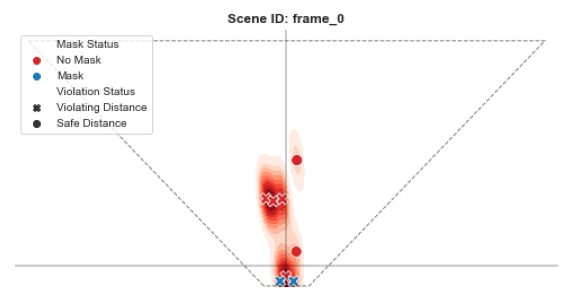

In [39]:
plt.figure(figsize=(10,7))
plt.imshow(result_img)
plt.axis('off')
plt.show()

In [40]:
# reset plotting settings (if not already done)
%matplotlib inline
sns.set_style('white')

In [41]:
# if true, use only final set of homography params for scene
# helps keep things smoother / more consistent throughout
USE_FINAL_HOMOGRAPHY = True

frame_heatmaps = []

# if chosen use only final set of homography params for video of scene
if USE_FINAL_HOMOGRAPHY:
    _, final_frame_params, _ = get_frame_data(person_results, frame_results, 
                                list(frame_results['image_id'].unique())[-1])

# iterate through all frames and get density heatmap for each
for chosen_id in list(frame_results['image_id'].unique()):
    
    # get appropriate results for chosen frame to plot our density heatmap
    frame_person_results, frame_params, img_dims = get_frame_data(person_results, 
                                                                  frame_results, 
                                                                  chosen_id)
    
    # modify params to final params if selected
    if USE_FINAL_HOMOGRAPHY:
        frame_params = final_frame_params.copy()
        
    # get risk-based weights for each person
    weights = get_sample_weights(frame_person_results)

    # get heatmap (as an image) for each frame
    frame_heatmap = get_density_heatmap(frame_person_results, weights, frame_params, 
                                        img_dims, figsize=(7,6), 
                                        title=f"Scene ID: {chosen_id}")
    
    frame_heatmaps.append(frame_heatmap)

**Animation of all heatmaps for current scene:**

Lets show this as a sequence of heatmaps for the original video.

**Note** - you need to ensure you run matplotlib in notebook mode (or open the plot in a pop-out window) in order to visualise the animation sequence below.

In [42]:
from matplotlib import animation

# need to enable matplotlib notebook to show animations
%matplotlib notebook

<IPython.core.display.Javascript object>


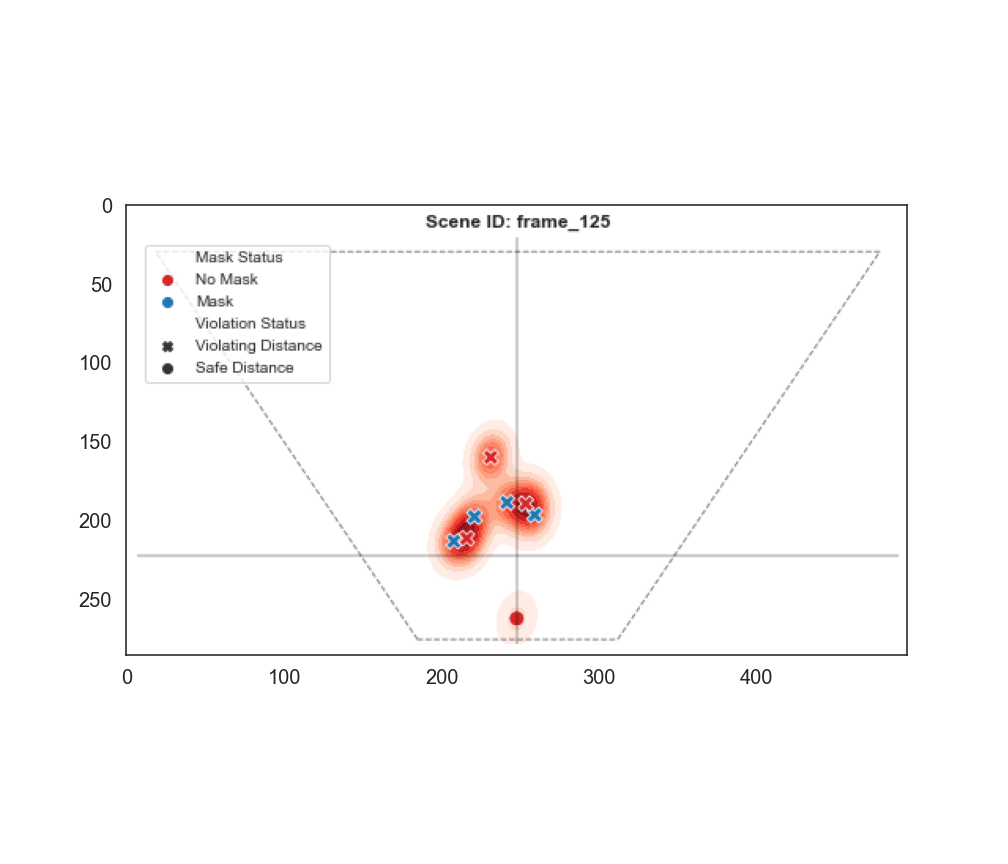

In [43]:
fig, ax = plt.subplots(figsize=(7,6))

ims = []
for i in range(len(frame_heatmaps)):
    im = ax.imshow(frame_heatmaps[i], animated=True)
    ims.append([im])

# animate our heatmap based on modelling fps chosen earlier
# make this slower (by 50%) to improve readability in this example
ani = animation.ArtistAnimation(fig, ims, interval=2000/MODELLING_FPS, 
                                blit=True, repeat=False)
plt.show()

Lets save this animation as a .gif for convenience of demonstrating various results:

In [44]:
f = f"{TEST_VIDEO_DIR}/{TEST_VIDEO_FILE[:-4]}_heatmap_animation.gif" 
writergif = animation.PillowWriter(fps=MODELLING_FPS) 
ani.save(f, writer=writergif)

**Animation of all heatmaps above videos for current scene:**

Lets show this as a sequence of heatmaps above the original video.

In [ ]:
def get_density_heatmap_on_video(frame, person_df, sample_weights, 
                                 hgraphy_params, image_dims, 
                                 bw_adjust=BW_ADJUST, alpha=0.5,
                                 figsize=(7,6), 
                                 title="Risk Density Heatmap"):
    """ Helper function for plotting density heatmap of scene on original view.
    
    Args:
        frame (np.array) : Original image array.
        person_df (pd.DataFrame) : Person results for chosen frame.
        sample_weights (np.ndarray): risk-based weights for each sample.
        hgraphy_params (np.ndarray) : Array of three elements, containing
            frame homography H, theta & f, precisely as so: [H, theta, f].
        image_dims (np.array) : Array containing x and y dims of scene image.
        bw_adjust (float) : value for adjusting bandwidth of gaussian KDE.
        alpha (float) : transparency value of heatmap on original image.
        figsize (tuple): tuple of desired figure size to plot.
    """
    # get x and y co-ords of persons for kde plot
    frame_posns = np.stack(person_df['position'].apply(np.array).values, 
                           axis=0)
    
    # break person positions into two seperate columns
    person_df['x_posn'] = person_df['position'].apply(lambda x : x[0])
    person_df['y_posn'] = person_df['position'].apply(lambda x : x[1])

    # set more readable output prediction labels for our risk-features
    person_df['Mask Status'] = person_df['mask_preds'].replace(MASK_PREDS_IDS)
    respect_col = 'respect_social_distancing'
    person_df['Violation Status'] = person_df[respect_col].replace(SOCIAL_DIST_IDS)

    # get observed area and limits of our scene top-down plot
    limits = np.array([[-image_dims[0]/2, -image_dims[1]/2], 
                       [-image_dims[0]/2, image_dims[1]/2], 
                       [image_dims[0]/2, image_dims[1]/2], 
                       [image_dims[0]/2, -image_dims[1]/2]])
    
    # get x and y limits for scene
    limits_y = (hgraphy_params[0] * limits[:, 1] / 
                (hgraphy_params[2]*np.sin(hgraphy_params[1])**2 - 
                 limits[:, 1]*np.cos(hgraphy_params[1])*np.sin(hgraphy_params[1])))
    
    limits_x = limits_y * limits[:, 0] * np.sin(hgraphy_params[1]) / limits[:, 1]         
    
    # get axis and limits
    m_x, M_x = np.min(limits_x), np.max(limits_x)
    m_y, M_y = np.min(limits_y), np.max(limits_y)
    
    # get top-view density heatmap
    fig = Figure()
    canvas = FigureCanvas(fig)
    ax = fig.subplots()
    ax = fig.add_axes([0, 0, 1, 1])
    
    sns.kdeplot(x=frame_posns[:, 0], y=frame_posns[:, 1], 
                shade=True, ax=ax, bw_adjust=bw_adjust, cmap="Reds", 
                weights=sample_weights, alpha=alpha)
    
    ax.set_xlim(m_x, M_x)
    ax.set_ylim(m_y, M_y)
    canvas.draw()
    
    # get heatmap as image array
    heatmap = np.array(canvas.renderer.buffer_rgba())
    
    # get homography to convert top-view to original camera view
    homography, _ = cv2.findHomography(np.column_stack([(limits_x - m_x)/(M_x - m_x)*heatmap.shape[1],
                                                        (M_y - limits_y)/(M_y - m_y)*heatmap.shape[0]]),
                                       np.column_stack([limits[:, 0], -limits[:, 1]]) +
                                       np.array([image_dims[0]/2, image_dims[1]/2]))
    
    # convert heatmap to original camera view
    img_out = cv2.warpPerspective(heatmap, homography, (image_dims[0], image_dims[1]))
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # plot original image and corresponding heatmap
    plt.imshow(frame)
    plt.imshow(img_out)

    plt.title(title, weight="bold")
    plt.legend(loc="upper left")
    plt.axis("off")
    plt.tight_layout()
    
    # save plot as BytesIO object
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    plt.close()
    
    return np.array(img)

In [ ]:
### get frames of the video

frames = []

# load uploaded video into opencv:
cap = cv2.VideoCapture(TEST_VIDEO_FILEPATH)
fps = cap.get(cv2.CAP_PROP_FPS)

# initially current frame is zero
frame_count = 0

# whilst processing video, do the following loop..
while(True):

    # check video capture, and obtain current frame (image from video)
    ret, frame = cap.read()

    # if our video is still being processed, do the following...
    if(ret):

        # preprocess frame as required for object detector & AlphaPose
        frame = mx.nd.array(cv2.cvtColor(frame, 
                                         cv2.COLOR_BGR2RGB)).astype('uint8')
        x, frame = gluoncv.data.transforms.presets.ssd.transform_test(frame, 
                                                        short=VID_RESIZE_SHORT)
        x = x.as_in_context(ctx)

        # obtain human bounding boxes using object detector
        class_IDs, scores, bounding_boxs = detector(x)

        # get pose estimations using AlphaPose
        pose_input, upscale_bbox = detector_to_alpha_pose(frame, class_IDs, 
                                                          scores, bounding_boxs)

        # if we have predictions, obtain keypoint co-ords and confidences
        if upscale_bbox is not None:
            
            frames.append(frame)
        
        # increment current frame by amount selected by MODELLING_FPS
        frame_count += fps / MODELLING_FPS
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_count))

    # break loop if video is not available / ended
    else:
        break

    if cv2.waitKey(1) == 27:
        break

### get corresponding heatmaps

# if true, use only final set of homography params for scene
# helps keep things smoother / more consistent throughout
USE_FINAL_HOMOGRAPHY = True

frame_heatmaps = []

# if chosen use only final set of homography params for video of scene
if USE_FINAL_HOMOGRAPHY:
    _, final_frame_params, _ = get_frame_data(person_results, frame_results, 
                                list(frame_results['image_id'].unique())[-1])

# iterate through all frames and get density heatmap for each
for i, chosen_id in enumerate(list(frame_results['image_id'].unique())):
    
    # get appropriate results for chosen frame to plot our density heatmap
    frame_person_results, frame_params, img_dims = get_frame_data(person_results, 
                                                                  frame_results, 
                                                                  chosen_id)
    
    # modify params to final params if selected
    if USE_FINAL_HOMOGRAPHY:
        frame_params = final_frame_params.copy()
        
    # get risk-based weights for each person
    weights = get_sample_weights(frame_person_results)

    # get heatmap (as an image) for each frame
    frame_heatmap = get_density_heatmap_on_video(frames[i], frame_person_results, weights,
                                                 frame_params, img_dims, alpha=0.5, figsize=(7,6),
                                                 title=f"Scene ID: {chosen_id}")
    
    frame_heatmaps.append(frame_heatmap)
        
        
# empty video capture cache
cap.release()
cv2.destroyAllWindows()

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

ims = []
for i in range(len(frame_heatmaps)):
    im = ax.imshow(frame_heatmaps[i], animated=True)
    ims.append([im])

# animate our heatmap based on modelling fps chosen earlier
# make this slower (by 50%) to improve readability in this example
ani = animation.ArtistAnimation(fig, ims, interval=2000/MODELLING_FPS, 
                                blit=True, repeat=False)
plt.show()

In [ ]:
f = f"{TEST_VIDEO_DIR}/{TEST_VIDEO_FILE[:-4]}_heatmap_v2_animation.gif" 
writergif = animation.PillowWriter(fps=MODELLING_FPS) 
ani.save(f, writer=writergif)

TO-DO:
- Work out a means of getting a suitable underlay of the top-down area for the scene, which will help represent the risky locations throughout that scene more effectively.
- Extend the work with heatmaps to produce a heatmap averaged over n timeframes, which will give an overall risk rating heatmap for that area over a designated time-period. One way of doing this could be to simply include all persons and weights across all n timesteps into the kde plot, which would represent the total heatmap across all frames.